Лабораторная работа 3. Обучение с учителем. Задача регрессии

Изучить примеры в тетрадках: Lab3_Ex1 MR_PolR.ipynb, Lab3_Ex2 SR-MR-PolR.ipynb
Реализовать настройку окружения (см. Как подготовить окружение.pdf).

ЗАДАНИЕ.
1. В соответствии с индивидуальным вариантом загрузить датасет (см. ML 3 semestr datasets) для решения задачи регрессии, выполнить предварительную обработку и разведочный анализ данных (EDA).
2. Выделить целевой признак и предикторы, разбить данные на обучающую и тестовую выборку.
3. Решить задачу регрессии на ваших данных с использованием моделей sklearn (простая линейная регрессия + L1, L2; множественная линейная регрессия + L1, L2), для моделей с регуляризациями подберите гиперпараметр.
4. Решить задачу регрессии на ваших данных с использованием моделей sklearn (Полиномиальная регрессия + L1, L2), для моделей с регуляризациями подберите гиперпараметр.
5. Вычислить значения метрик R2, MAE, MSE, RMSE, MAPE для всех обученных моделей. Выбрать лучшую модель.
6. Реализовать пайплайн при построении модели регрессии.
7. *Самостоятельно реализовать вычисление всех используемых метрик (в виде функций, принимающих два аргумента). Привести в таблице метрики, вычисленные с использование библиотеки Scikit-learn и соответствующими пользовательскими функциями.

# Инициализация проекта.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from math import sqrt
import numpy as np

import sys
sys.path.append(r"D:\university\ML\MyLib")
import regression_metrics

pd.set_option('display.max_columns', None)

In [2]:
data = pd.read_csv('../data/moldova_cars_task.csv')

# 1.Обработка данных

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41007 entries, 0 to 41006
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Make                  41007 non-null  object 
 1   Model                 40671 non-null  object 
 2   Year                  40771 non-null  float64
 3   Style                 40938 non-null  object 
 4   Distance              40889 non-null  float64
 5   Engine_capacity(cm3)  41007 non-null  float64
 6   Fuel_type             41007 non-null  object 
 7   Transmission          40779 non-null  object 
 8   Price(euro)           41007 non-null  float64
dtypes: float64(4), object(5)
memory usage: 2.8+ MB


## 1.1 Удалим объекты, где указана не вся информация

In [4]:
data.isna().sum()

Make                      0
Model                   336
Year                    236
Style                    69
Distance                118
Engine_capacity(cm3)      0
Fuel_type                 0
Transmission            228
Price(euro)               0
dtype: int64

In [5]:
data = data.dropna() 
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40030 entries, 0 to 41006
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Make                  40030 non-null  object 
 1   Model                 40030 non-null  object 
 2   Year                  40030 non-null  float64
 3   Style                 40030 non-null  object 
 4   Distance              40030 non-null  float64
 5   Engine_capacity(cm3)  40030 non-null  float64
 6   Fuel_type             40030 non-null  object 
 7   Transmission          40030 non-null  object 
 8   Price(euro)           40030 non-null  float64
dtypes: float64(4), object(5)
memory usage: 3.1+ MB


In [6]:
data

,Make,Model,Year,Style,Distance,Engine_capacity(cm3),Fuel_type,Transmission,Price(euro)
0,Toyota,Prius,2011.0,Hatchback,195000.0,1800.0,Hybrid,Automatic,7750.0
1,Renault,Grand Scenic,2014.0,Universal,135000.0,1500.0,Diesel,Manual,8550.0
2,Volkswagen,Golf,1998.0,Hatchback,1.0,1400.0,Petrol,Manual,2200.0
3,Renault,Laguna,2012.0,Universal,110000.0,1500.0,Diesel,Manual,6550.0
4,Opel,Astra,2006.0,Universal,200000.0,1600.0,Metan/Propan,Manual,4100.0
...,...,...,...,...,...,...,...,...,...
41001,Land Rover,Freelander,2002.0,Crossover,225000.0,1800.0,Metan/Propan,Manual,4400.0
41003,Renault,Modus,2009.0,Hatchback,225.0,1500.0,Diesel,Manual,4500.0
41004,Mercedes,E Class,2016.0,Sedan,50000.0,1950.0,Diesel,Automatic,29500.0
41005,Mazda,6,2006.0,Combi,370000.0,2000.0,Diesel,Manual,4000.0


## 1.2 Удалим дубликаты

In [7]:
data.duplicated().sum()

3589

In [8]:
print(data.duplicated().sum())
data=data.drop_duplicates()
print(data.duplicated().sum())

3589
0


## 1.3 Отформатируем названия столбцов 

In [9]:
data.columns

Index(['Make', 'Model', 'Year', 'Style', 'Distance', 'Engine_capacity(cm3)',
       'Fuel_type', 'Transmission', 'Price(euro)'],
      dtype='object')

In [10]:
data=data.rename(
    columns={
        'Engine_capacity(cm3)':'Engine_capacity',
        'Price(euro)':'Price'
    }
)

## 1.4 Обработаем категориальные данные 

In [11]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

#le.fit(data["Make"])
#data['Make'] = le.transform(data['Make'])

dummies = pd.get_dummies(data.Make, dtype=float)
data = pd.concat([data, dummies], axis='columns')
data = data.drop(['Make'], axis='columns')

#le.fit(data["Model"])
#data['Model'] = le.transform(data['Model'])

dummies = pd.get_dummies(data.Model, dtype=float)
data = pd.concat([data, dummies], axis='columns')
data = data.drop(['Model'], axis='columns')

#le.fit(data["Style"])
#data['Style'] = le.transform(data['Style'])

dummies = pd.get_dummies(data.Style, dtype=float)
data = pd.concat([data, dummies], axis='columns')
data = data.drop(['Style'], axis='columns')

#le.fit(data["Fuel_type"])
#data["Fuel_type"] = le.transform(data["Fuel_type"])

dummies = pd.get_dummies(data.Fuel_type, dtype=float)
data = pd.concat([data, dummies], axis='columns')
data = data.drop(['Fuel_type'], axis='columns')

#le.fit(data["Transmission"])
#data["Transmission"] = le.transform(data["Transmission"])

data['Transmission'].replace(['Manual', 'Automatic'],
                        [0, 1], inplace=True)

In [12]:
data

,Year,Distance,Engine_capacity,Transmission,Price,ARO,Abarth,Acura,Alfa Romeo,Alta marca,Aston Martin,Audi,BAIC,BMW,Bentley,Brilliance,Buick,Byd,Cadillac,Changan,Chery,Chevrolet,Chrysler,Citroen,Dacia,Daewoo,Daihatsu,Datsun,Dodge,Faw,Ferrari,Fiat,Ford,GAZ,GMC,Geely,Great Wall,Groz,Haima,Haval,Honda,Hummer,Hyundai,Infiniti,Isuzu,Jac,Jaguar,Jeep,KIA,Lada,Lamborghini,Lancia,Land Rover,Lexus,Lifan,Lincoln,LuAZ,Maserati,Mazda,McLaren,Mercedes,Mercedes-Maybach,Mini,Mitsubishi,Moskvich / Izh,Nissan,Opel,Peugeot,Pontiac,Porsche,Ravon,Renault,Rover,Saab,Saturn,Scion,Seat,Skoda,Smart,Ssangyong,Subaru,Suzuki,Tata,Tesla,Toyota,UAZ,Vaz,Volkswagen,Volvo,Xpeng,Zaz,Zotye,1 Series,100,1007,106,107,108,1102 Tavria,121,145,147,156,159,166,19,190,2,2 Series,200,200 Series,2008,205,206,207,208,21,2101,2102,2103,2104,2105,2106,2107,2108,2109,21099,2110,2111,2112,2113,2114,2115,2121niva,2123 Chevrolet,2125,2129 Niva Long,2140,2141,2410,25,3,3 GT,3 Series,3008,300c,300m,301,306,307,308,309,31029,3110,323,4 series,4-Runner,400 Series,4007,401,405,406,407,408,45,469,5,5 GT,5 Series,500,5008,500L,508,6,6 Series,600 Series,605,607,620,626,7 Series,700 Series,75,8 Series,80,800 Series,806,807,9-3,9-5,90,900 Series,9000,911,924,929,968,969,A Class,A1,A2,A3,A3 e-tron,A4,A5,A6,A7,A8,AMG GT,ASX,ATS,Accent,Accord,Actyon,Adam,Aerostar,Agila,Albea,Alhambra,Allroad,Almera,Almera Tino,Alt model,Altea,Altea XL,Altele,Altima,Alto,Amarok,Ampera,Antara,Applouse,Arosa,Arteon,Ascona,Astra,Atos,Auris,Avalanche,Avalon,Avante,Avenger,Avensis,Avensis Verso,Aventador,Aveo,Ax,Aygo,Azera,B Class,B-Max,B9 Tribeca,BRZ,BS3,BS6,BT-50,BX,Baleno,Beetle,Berlingo,Bipper,Blazer,Bls,Bluebird,Bolt,Bora,Boxster,Brava,Bravo,Breez,C Class,C-Class Coupe,C-Crosser,C-Elysee,C-HR,C-Max,C1,C2,C3,C3 Picasso,C30,C4,C4 Cactus,C4 Picasso,C5,C70,C8,CK,CL Class,CLA,CLC Class,CLK Class,CLS Class,CR-V,CR-Z,CS35PLUS,CT Series,CTS,CX,CX-3,CX-30,CX-5,CX-7,CX-9,Caddy,Caliber,Calibra,Camaro,Camry,Captiva,Captur,Caravan,Caravelle,Carens,Carina,Carisma,Carnival,Cayenne,Cayenne Coupe,Cayman,Ceed,Ceed Sw,Celica,Cerato,Challenger,Charger,Cherokee,Cherry,Chery Van,Citan,Citigo,City K-ZE,Civic,Civic Hibrid,Clarity,Clarus,Clio,Clio Symbol,Clio4,Clubman,Colt,Combo,Commander,Compass,Concerto,Continental,Cooper,Cooper S,Cordoba,Corolla,Corolla Verso,Corsa,Corvette,Countryman,Coupe,Courier,Creta,Croma,Crosseastar,Crosstrek,Crown,Cruze,Cuore,D20,D50,DS3,DS4,DS5,Dakota,Dedra,Defender,Delta,Discovery,Discovery Sport,Doblo,Doblo Cargo,Doblo Panorama,Dokker,Dokker VAN,Durango,Duster,E Class,E-Class Coupe,E-Pace,EU5,Eastar,Eclipse,Eclipse Cross,EcoSport,Edge,Elantra,Encore,Envision,Envoy,Eos,Epica,Equinox,Equus,Es Series,Escalade,Escape,Escort,Espace,Espero,Evanda,Excursion,Exeo,Expedition,Expert,Explorer,Express,F-150,F-250,F-PACE,F-Type,F3,F6,FR-V,FSV,FX,Fabia,Fabia RS,Favorit,Felicia,Fiesta,Fiesta 3D,Fiesta 5D,Fiorino,Fluence,Focus,Focus Rs,Focus Wagon,Forester,Forfour,Fortuner,Fortwo,Fox,Freelander,Freema,Frontera,Frontier,Fullback,Fusion,G Class,G Series,G3,GL Class,GLA,GLC,GLC Coupe,GLE,GLE Coupe,GLK Class,GLS Klass,GS Series,GT86,GW Peri,GX Series,Galant,Galaxy,Galloper,Genesis,Getz,Ghibli II,Giulia,Giulietta,Gol,Golf,Golf Plus,Granada,Grand - Am,Grand Caravan,Grand Cherokee,Grand Espace,Grand Modus,Grand Scenic,Grand Vitara,Grand Voyager,Grande Punto,Grande Punto 5D,Grandeur,Grandis,Grandland X,Granta,Gt,H-1 Truck,H2,H200,H3,H6,H9,HHR,HR-V,Hiace,Highlander,Hilux,Hover,Hunter,I-Pace,ILX,IONIQ,IS Series,Ibiza,Ignis,Impala,Impreza,Inca,Insight,Insignia,Intrepid,J7,JS4,Jazz,Jetta,Jimny,Jolion,Journey,Juke,Jumpy,Justy,Ka,Kadett,Kadjar,Kalina,Kalos,Kangoo,Kappa,Karoq,Kicks,Kodiaq,Koleos,Kona,Korando,Kuga,Kyron,L,L Series,LS Series,LX Series,Lacetti,Laguna,Lancer,Land Cruiser,Land Cruiser Prado,Lanos,Lantra,Largus,Leaf,Legacy,Leon,Levante,Liana,Lodgy,Logan,Logan Mcv,Logan Van,Logo,Lumina,Lupo,Lybra,M Class,M Models,M Series,"M-20 ""Pobeda""",MDX,MKC,MKZ,MPV,MX-30,MX-5,MX-6,Macan,Magentis,Magnum,Malibu,Marea,Materia,Matiz,Mat

# 2 EDA

Выведим описательную статистику

In [13]:
data.describe()

Year      Distance  Engine_capacity  Transmission  \
count  36441.000000  3.644100e+04     36441.000000  36441.000000   
mean    2007.723059  4.759444e+05      1859.135123      0.444664   
std        8.287601  4.582778e+06       707.513603      0.496935   
min     1900.000000  0.000000e+00         0.000000      0.000000   
25%     2004.000000  9.000000e+04      1499.000000      0.000000   
50%     2009.000000  1.700000e+05      1800.000000      0.000000   
75%     2014.000000  2.300000e+05      2000.000000      1.000000   
max     2021.000000  1.000000e+08      9999.000000      1.000000   

              Price           ARO        Abarth         Acura    Alfa Romeo  \
count  3.644100e+04  36441.000000  36441.000000  36441.000000  36441.000000   
mean   9.589220e+03      0.000055      0.000027      0.000384      0.001153   
std    5.340259e+04      0.007408      0.005238      0.019597      0.033930   
min    1.000000e+00      0.000000      0.000000      0.000000      0.000000   
25%    3.333000e+03      0.000000      0.000000      0.000000      0.000000   
50%    6.499000e+03      0.000000      0.000000      0.000000      0.000000   
75%    1.180000e+04      0.000000      0.000000      0.000000      0.000000   
max    1.000000e+07      1.000000      1.000000      1.000000      1.000000   

         Alta marca  Aston Martin          Audi          BAIC           BMW  \
count  36441.000000  36441.000000  36441.000000  36441.000000  36441.000000   
mean       0.000686      0.000027      0.048187      0.000082      0.080514   
std        0.026184      0.005238      0.214165      0.009073      0.272091   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

            Bentley    Brilliance         Buick           Byd      Cadillac  \
count  36441.000000  36441.000000  36441.000000  36441.000000  36441.000000   
mean       0.000137      0.000439      0.000137      0.000467      0.000686   
std        0.011713      0.020950      0.011713      0.021594      0.026184   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

            Changan         Chery     Chevrolet      Chrysler       Citroen  \
count  36441.000000  36441.000000  36441.000000  36441.000000  36441.000000   
mean       0.000110      0.000521      0.009852      0.002607      0.009028   
std        0.010477      0.022828      0.098766      0.050992      0.094589   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

              Dacia        Daewoo      Daihatsu        Datsun         Dodge  \
count  36441.000000  36441.000000  36441.000000  36441.000000  36441.000000   
mean       0.040861      0.002113      0.000851      0.000082      0.001784   
std        0.197970      0.045919      0.029155      0.009073      0.042197   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
7

### Обработка выбросов

Выведим графики 

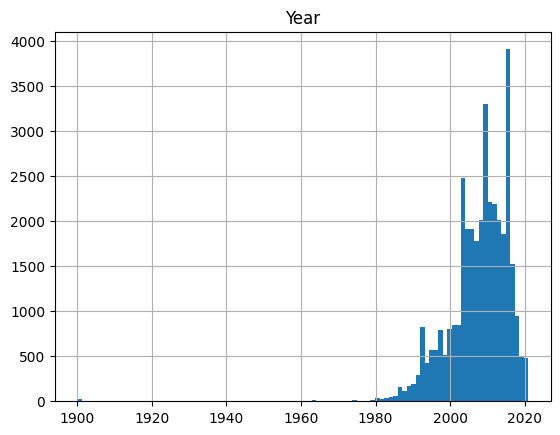

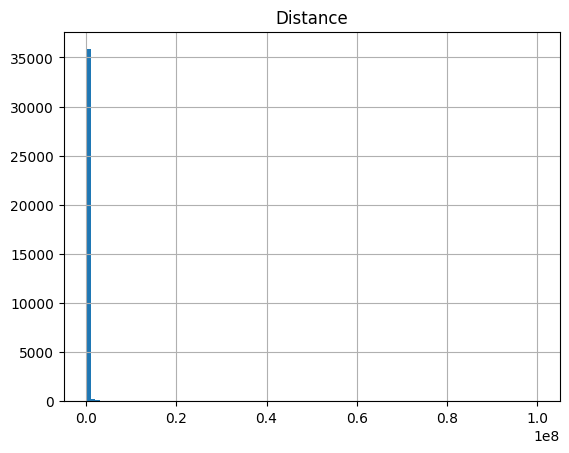

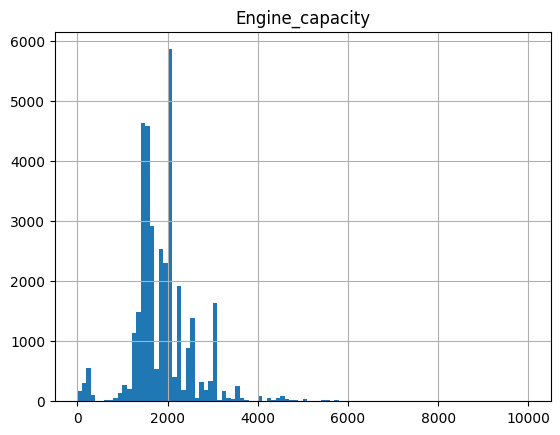

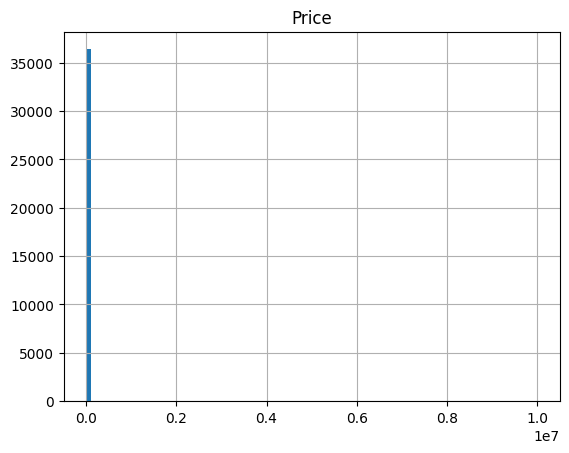

In [14]:
columns = ['Year','Distance','Engine_capacity','Price']

for col in columns:
    data.hist(col, bins=100)

Можно заметить, что по каждому признаку имеются выбросы  

In [15]:
outlier = data[['Year','Distance','Engine_capacity','Price']]
outlier

,Year,Distance,Engine_capacity,Price
0,2011.0,195000.0,1800.0,7750.0
1,2014.0,135000.0,1500.0,8550.0
2,1998.0,1.0,1400.0,2200.0
3,2012.0,110000.0,1500.0,6550.0
4,2006.0,200000.0,1600.0,4100.0
...,...,...,...,...
41000,2016.0,88000.0,1800.0,11500.0
41001,2002.0,225000.0,1800.0,4400.0
41003,2009.0,225.0,1500.0,4500.0
41005,2006.0,370000.0,2000.0,4000.0


In [16]:
Q1 = outlier.quantile(0.25)
Q1

Year                2004.0
Distance           90000.0
Engine_capacity     1499.0
Price               3333.0
Name: 0.25, dtype: float64

In [17]:
Q3 = outlier.quantile(0.75)
Q3

Year                 2014.0
Distance           230000.0
Engine_capacity      2000.0
Price               11800.0
Name: 0.75, dtype: float64

In [18]:
# убираем выбросы
IQR=Q3-Q1
data_filtered = outlier[~((outlier < (Q1 - 1.5 * IQR)) |(outlier > (Q3 + 1.5 * IQR))).any(axis=1)]
data_filtered

,Year,Distance,Engine_capacity,Price
0,2011.0,195000.0,1800.0,7750.0
1,2014.0,135000.0,1500.0,8550.0
2,1998.0,1.0,1400.0,2200.0
3,2012.0,110000.0,1500.0,6550.0
4,2006.0,200000.0,1600.0,4100.0
...,...,...,...,...
41000,2016.0,88000.0,1800.0,11500.0
41001,2002.0,225000.0,1800.0,4400.0
41003,2009.0,225.0,1500.0,4500.0
41005,2006.0,370000.0,2000.0,4000.0


In [19]:
index_list = list(data_filtered.index.values)
data_filtered = data[data.index.isin(index_list)]
data_filtered

,Year,Distance,Engine_capacity,Transmission,Price,ARO,Abarth,Acura,Alfa Romeo,Alta marca,Aston Martin,Audi,BAIC,BMW,Bentley,Brilliance,Buick,Byd,Cadillac,Changan,Chery,Chevrolet,Chrysler,Citroen,Dacia,Daewoo,Daihatsu,Datsun,Dodge,Faw,Ferrari,Fiat,Ford,GAZ,GMC,Geely,Great Wall,Groz,Haima,Haval,Honda,Hummer,Hyundai,Infiniti,Isuzu,Jac,Jaguar,Jeep,KIA,Lada,Lamborghini,Lancia,Land Rover,Lexus,Lifan,Lincoln,LuAZ,Maserati,Mazda,McLaren,Mercedes,Mercedes-Maybach,Mini,Mitsubishi,Moskvich / Izh,Nissan,Opel,Peugeot,Pontiac,Porsche,Ravon,Renault,Rover,Saab,Saturn,Scion,Seat,Skoda,Smart,Ssangyong,Subaru,Suzuki,Tata,Tesla,Toyota,UAZ,Vaz,Volkswagen,Volvo,Xpeng,Zaz,Zotye,1 Series,100,1007,106,107,108,1102 Tavria,121,145,147,156,159,166,19,190,2,2 Series,200,200 Series,2008,205,206,207,208,21,2101,2102,2103,2104,2105,2106,2107,2108,2109,21099,2110,2111,2112,2113,2114,2115,2121niva,2123 Chevrolet,2125,2129 Niva Long,2140,2141,2410,25,3,3 GT,3 Series,3008,300c,300m,301,306,307,308,309,31029,3110,323,4 series,4-Runner,400 Series,4007,401,405,406,407,408,45,469,5,5 GT,5 Series,500,5008,500L,508,6,6 Series,600 Series,605,607,620,626,7 Series,700 Series,75,8 Series,80,800 Series,806,807,9-3,9-5,90,900 Series,9000,911,924,929,968,969,A Class,A1,A2,A3,A3 e-tron,A4,A5,A6,A7,A8,AMG GT,ASX,ATS,Accent,Accord,Actyon,Adam,Aerostar,Agila,Albea,Alhambra,Allroad,Almera,Almera Tino,Alt model,Altea,Altea XL,Altele,Altima,Alto,Amarok,Ampera,Antara,Applouse,Arosa,Arteon,Ascona,Astra,Atos,Auris,Avalanche,Avalon,Avante,Avenger,Avensis,Avensis Verso,Aventador,Aveo,Ax,Aygo,Azera,B Class,B-Max,B9 Tribeca,BRZ,BS3,BS6,BT-50,BX,Baleno,Beetle,Berlingo,Bipper,Blazer,Bls,Bluebird,Bolt,Bora,Boxster,Brava,Bravo,Breez,C Class,C-Class Coupe,C-Crosser,C-Elysee,C-HR,C-Max,C1,C2,C3,C3 Picasso,C30,C4,C4 Cactus,C4 Picasso,C5,C70,C8,CK,CL Class,CLA,CLC Class,CLK Class,CLS Class,CR-V,CR-Z,CS35PLUS,CT Series,CTS,CX,CX-3,CX-30,CX-5,CX-7,CX-9,Caddy,Caliber,Calibra,Camaro,Camry,Captiva,Captur,Caravan,Caravelle,Carens,Carina,Carisma,Carnival,Cayenne,Cayenne Coupe,Cayman,Ceed,Ceed Sw,Celica,Cerato,Challenger,Charger,Cherokee,Cherry,Chery Van,Citan,Citigo,City K-ZE,Civic,Civic Hibrid,Clarity,Clarus,Clio,Clio Symbol,Clio4,Clubman,Colt,Combo,Commander,Compass,Concerto,Continental,Cooper,Cooper S,Cordoba,Corolla,Corolla Verso,Corsa,Corvette,Countryman,Coupe,Courier,Creta,Croma,Crosseastar,Crosstrek,Crown,Cruze,Cuore,D20,D50,DS3,DS4,DS5,Dakota,Dedra,Defender,Delta,Discovery,Discovery Sport,Doblo,Doblo Cargo,Doblo Panorama,Dokker,Dokker VAN,Durango,Duster,E Class,E-Class Coupe,E-Pace,EU5,Eastar,Eclipse,Eclipse Cross,EcoSport,Edge,Elantra,Encore,Envision,Envoy,Eos,Epica,Equinox,Equus,Es Series,Escalade,Escape,Escort,Espace,Espero,Evanda,Excursion,Exeo,Expedition,Expert,Explorer,Express,F-150,F-250,F-PACE,F-Type,F3,F6,FR-V,FSV,FX,Fabia,Fabia RS,Favorit,Felicia,Fiesta,Fiesta 3D,Fiesta 5D,Fiorino,Fluence,Focus,Focus Rs,Focus Wagon,Forester,Forfour,Fortuner,Fortwo,Fox,Freelander,Freema,Frontera,Frontier,Fullback,Fusion,G Class,G Series,G3,GL Class,GLA,GLC,GLC Coupe,GLE,GLE Coupe,GLK Class,GLS Klass,GS Series,GT86,GW Peri,GX Series,Galant,Galaxy,Galloper,Genesis,Getz,Ghibli II,Giulia,Giulietta,Gol,Golf,Golf Plus,Granada,Grand - Am,Grand Caravan,Grand Cherokee,Grand Espace,Grand Modus,Grand Scenic,Grand Vitara,Grand Voyager,Grande Punto,Grande Punto 5D,Grandeur,Grandis,Grandland X,Granta,Gt,H-1 Truck,H2,H200,H3,H6,H9,HHR,HR-V,Hiace,Highlander,Hilux,Hover,Hunter,I-Pace,ILX,IONIQ,IS Series,Ibiza,Ignis,Impala,Impreza,Inca,Insight,Insignia,Intrepid,J7,JS4,Jazz,Jetta,Jimny,Jolion,Journey,Juke,Jumpy,Justy,Ka,Kadett,Kadjar,Kalina,Kalos,Kangoo,Kappa,Karoq,Kicks,Kodiaq,Koleos,Kona,Korando,Kuga,Kyron,L,L Series,LS Series,LX Series,Lacetti,Laguna,Lancer,Land Cruiser,Land Cruiser Prado,Lanos,Lantra,Largus,Leaf,Legacy,Leon,Levante,Liana,Lodgy,Logan,Logan Mcv,Logan Van,Logo,Lumina,Lupo,Lybra,M Class,M Models,M Series,"M-20 ""Pobeda""",MDX,MKC,MKZ,MPV,MX-30,MX-5,MX-6,Macan,Magentis,Magnum,Malibu,Marea,Materia,Matiz,Mat

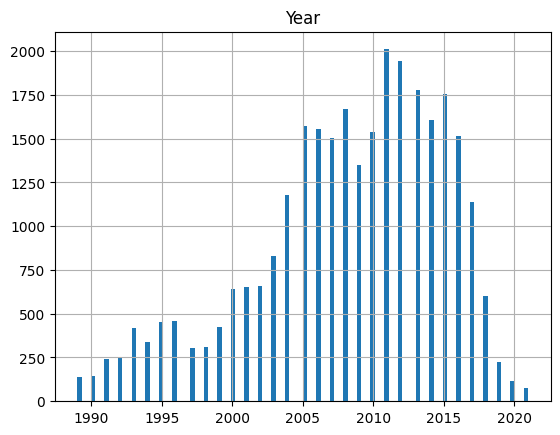

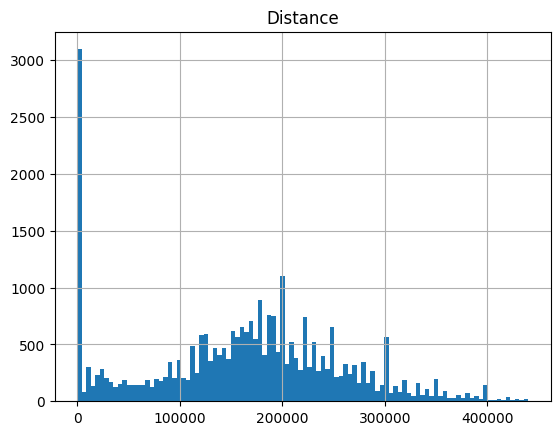

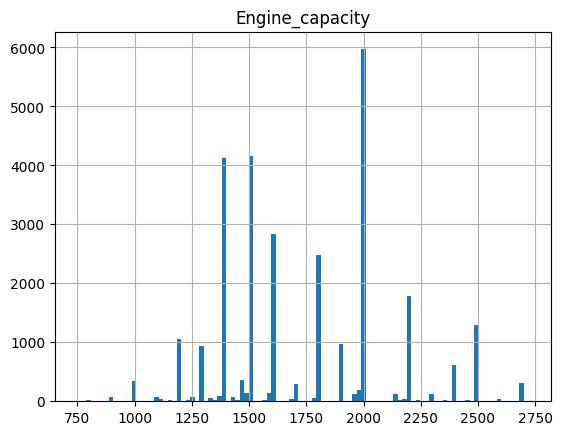

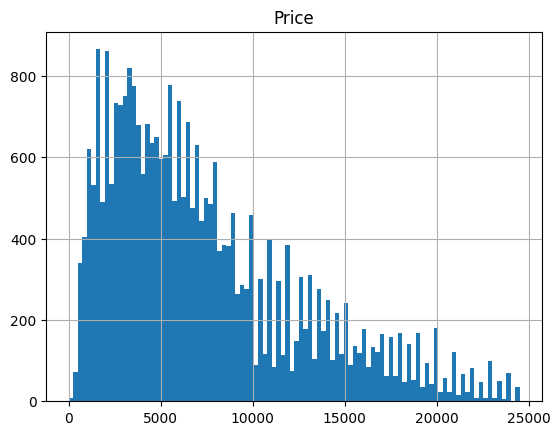

In [20]:
filtered_outlier = data_filtered[['Year','Distance','Engine_capacity','Price']]
for col in filtered_outlier:
    data_filtered.hist(col, bins=100)

# 3.Линейная регрессия


## 3.1 Простая линейная регрессия

In [21]:
#data_filtered.corr()

In [22]:
pipeline = Pipeline(
    [
        ('minmaxscaler', MinMaxScaler()),
        ('model', LinearRegression()),
    ]
)

In [23]:
y=data_filtered["Price"].values.reshape(-1,1)
X=data_filtered['Year'].values.reshape(-1,1)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
slr = pipeline.fit(X_train, y_train)
slr.predict(X_test)
y_pred = slr.predict(X_test)

print(f'MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'MSE: {mean_squared_error(y_test, y_pred)}')
print(f'RMSE: {sqrt(mean_squared_error(y_test, y_pred))}')
print(f'MAPE: {sqrt(mean_absolute_percentage_error(y_test, y_pred))}')
print(f'R^2: {slr.score(X_test, y_test)}')

MAE: 2877.115527566109
MSE: 14228105.156530656
RMSE: 3772.016059951317
MAPE: 1.07994267488324
R^2: 0.47355063240138506


### L1

In [25]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [26]:
parameters = {'alpha': np.arange(0, 1, 0.1)}
ridge_optimal = GridSearchCV(Ridge(), parameters).fit(X_train, y_train)

pipeline = Pipeline(
    [
        ("scaler", MinMaxScaler()),
        ("model", Ridge(alpha=ridge_optimal.best_params_['alpha'])),
    ]
)

In [27]:
slr_ridge = pipeline.fit(X_train, y_train)
y_pred = slr_ridge.predict(X_test)
print(f'MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'MSE: {mean_squared_error(y_test, y_pred)}')
print(f'RMSE: {sqrt(mean_squared_error(y_test, y_pred))}')
print(f'MAPE: {sqrt(mean_absolute_percentage_error(y_test, y_pred))}')
print(f'R^2: {slr_ridge.score(X_test, y_test)}')

MAE: 2876.86492510501
MSE: 14227843.041529791
RMSE: 3771.9813151087837
MAPE: 1.0799966739013542
R^2: 0.473560330831002


### L2

In [28]:
parameters = {'alpha': np.arange(0, 1, 0.1)}
lasso_optimal = GridSearchCV(Lasso(), parameters).fit(X_train, y_train)

pipeline = Pipeline(
    [
        ("scaler", MinMaxScaler()),
        ("model", Lasso(alpha=lasso_optimal.best_params_['alpha'])),
    ]
)

D:\university\ML\venv\lib\site-packages\sklearn\base.py:1151: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
D:\university\ML\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
D:\university\ML\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.343e+11, tolerance: 5.233e+07 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent

In [29]:
slr_lasso = pipeline.fit(X_train, y_train)
y_pred = slr_lasso.predict(X_test)

print(f'MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'MSE: {mean_squared_error(y_test, y_pred)}')
print(f'RMSE: {sqrt(mean_squared_error(y_test, y_pred))}')
print(f'MAPE: {mean_absolute_percentage_error(y_test, y_pred)}')
print(f'R^2: {slr_lasso.score(X_test, y_test)}')

MAE: 2877.1155275661104
MSE: 14228105.156530656
RMSE: 3772.016059951317
MAPE: 1.1662761810339666
R^2: 0.47355063240138506


D:\university\ML\venv\lib\site-packages\sklearn\base.py:1151: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
D:\university\ML\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
D:\university\ML\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.663e+11, tolerance: 6.493e+07 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent

### Elastic

In [30]:
parameters = {'alpha': np.arange(0, 1, 0.1)}
elastic_optimal = GridSearchCV(ElasticNet(), parameters).fit(X_train, y_train)
pipeline = Pipeline(
    [
        ("scaler", MinMaxScaler()),
        ("model", ElasticNet(elastic_optimal.best_params_['alpha'])),
    ]
)

D:\university\ML\venv\lib\site-packages\sklearn\base.py:1151: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
D:\university\ML\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
D:\university\ML\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.343e+11, tolerance: 5.233e+07 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent

In [31]:
slr_elastic = pipeline.fit(X_train, y_train)
y_pred = slr_elastic.predict(X_test)

print(f'MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'MSE: {mean_squared_error(y_test, y_pred)}')
print(f'RMSE: {sqrt(mean_squared_error(y_test, y_pred))}')
print(f'MAPE: {sqrt(mean_absolute_percentage_error(y_test, y_pred))}')
print(f'R^2: {slr_elastic.score(X_test, y_test)}')

MAE: 2877.1155275661104
MSE: 14228105.156530656
RMSE: 3772.016059951317
MAPE: 1.0799426748832397
R^2: 0.47355063240138506


D:\university\ML\venv\lib\site-packages\sklearn\base.py:1151: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
D:\university\ML\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
D:\university\ML\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.663e+11, tolerance: 6.493e+07 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent

## 3.2 Множественная линейная регрессия

In [32]:
y = data_filtered["Price"]
X = data_filtered.drop(["Price"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2)

pipeline = Pipeline(
    [
        ("scaler", MinMaxScaler()),
        ("model",LinearRegression()),
    ]
)

In [33]:
mlr = pipeline.fit(X_train, y_train)
y_pred = mlr.predict(X_test)

print(f'MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'MSE: {mean_squared_error(y_test, y_pred)}')
print(f'RMSE: {sqrt(mean_squared_error(y_test, y_pred))}')
print(f'MAPE: {sqrt(mean_absolute_percentage_error(y_test, y_pred))}')
print(f'R^2: {mlr.score(X_test, y_test)}')

MAE: 146918752715.18704
MSE: 2.649547434897515e+25
RMSE: 5147375481638.691
MAPE: 6870.253363855795
R^2: -9.726654080903304e+17


### L1

In [34]:
parameters = {'alpha': np.arange(0, 1, 0.1)}
ridge_optimal = GridSearchCV(Ridge(), parameters).fit(X_train, y_train)
pipeline = Pipeline(
    [
        ("scaler", MinMaxScaler()),
        ("model", Ridge(alpha=ridge_optimal.best_params_['alpha'])),
    ]
)

In [35]:
mlr_ridge = pipeline.fit(X_train, y_train)
y_pred = mlr_ridge.predict(X_test)
print(f'MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'MSE: {mean_squared_error(y_test, y_pred)}')
print(f'RMSE: {sqrt(mean_squared_error(y_test, y_pred))}')
print(f'MAPE: {sqrt(mean_absolute_percentage_error(y_test, y_pred))}')
print(f'R^2: {mlr_ridge.score(X_test, y_test)}')

MAE: 1691.2928173842886
MSE: 5969178.7332574725
RMSE: 2443.190277742909
MAPE: 1.2827503571163732
R^2: 0.7808677213294513


### L2

In [36]:
parameters = {'alpha': np.arange(0, 1, 0.1)}
lasso_optimal = GridSearchCV(Lasso(), parameters).fit(X_train, y_train)
pipeline = Pipeline(
    [
        ("scaler", MinMaxScaler()),
        ("model", Lasso(alpha=lasso_optimal.best_params_['alpha'])),
    ]
)

D:\university\ML\venv\lib\site-packages\sklearn\base.py:1151: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
D:\university\ML\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
D:\university\ML\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.288e+10, tolerance: 5.162e+07 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent

In [37]:
mlr_lasso = pipeline.fit(X_train, y_train)

y_pred = mlr_lasso.predict(X_test)

print(f'MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'MSE: {mean_squared_error(y_test, y_pred)}')
print(f'RMSE: {sqrt(mean_squared_error(y_test, y_pred))}')
print(f'MAPE: {sqrt(mean_absolute_percentage_error(y_test, y_pred))}')
print(f'R^2: {mlr_lasso.score(X_test, y_test)}')

MAE: 1693.6824494117716
MSE: 5995440.768361812
RMSE: 2448.5589166613518
MAPE: 1.29036956332378
R^2: 0.7799036256217994


D:\university\ML\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.037e+08, tolerance: 6.481e+07
  model = cd_fast.enet_coordinate_descent(


### Elastic net

In [38]:
parameters = {'alpha': np.arange(0, 1, 0.1)}
elastic_optimal = RandomizedSearchCV(ElasticNet(), parameters).fit(X_train, y_train)
pipeline = Pipeline(
    [
        ("scaler", MinMaxScaler()),
        ("model", ElasticNet(elastic_optimal.best_params_['alpha'])),
    ]
)

D:\university\ML\venv\lib\site-packages\sklearn\base.py:1151: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
D:\university\ML\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
D:\university\ML\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.288e+10, tolerance: 5.162e+07 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent

In [39]:
mlr_elastic = pipeline.fit(X_train, y_train)
y_pred = mlr_elastic.predict(X_test)

print(f'MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'MSE: {mean_squared_error(y_test, y_pred)}')
print(f'RMSE: {sqrt(mean_squared_error(y_test, y_pred))}')
print(f'MAPE: {sqrt(mean_absolute_percentage_error(y_test, y_pred))}')
print(f'R^2: {mlr_elastic.score(X_test, y_test)}')

D:\university\ML\venv\lib\site-packages\sklearn\base.py:1151: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
D:\university\ML\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(


MAE: 1695.8007476743883
MSE: 6018516.1390937315
RMSE: 2453.2664223629954
MAPE: 1.332806170173871
R^2: 0.7790565143531285


D:\university\ML\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.758e+10, tolerance: 6.481e+07 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


## 3.3 Полиноминальная регрессия

In [40]:
y = data_filtered['Price'].values.reshape(-1,1)
X = data_filtered['Year'].values.reshape(-1,1)

p = PolynomialFeatures(2)

X_p=p.fit_transform(X)
X_p
    
X_train, X_test, y_train, y_test = train_test_split(X_p, y, test_size=0.2)

pr = LinearRegression().fit(X_train, y_train)

y_pred = pr.predict(X_test)

print(f'MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'MSE: {mean_squared_error(y_test, y_pred)}')
print(f'RMSE: {sqrt(mean_squared_error(y_test, y_pred))}')
print(f'MAPE: {sqrt(mean_absolute_percentage_error(y_test, y_pred))}')
print(f'R^2: {pr.score(X_test, y_test)}')

MAE: 2459.445507666919
MSE: 11205798.868099235
RMSE: 3347.506365654774
MAPE: 0.9703216551671496
R^2: 0.5787714908587764


### L1

In [41]:
parameters = {'alpha': np.arange(0, 1, 0.1)}

In [42]:
ridge_optimal = GridSearchCV(Ridge(), parameters).fit(X_train, y_train)

In [43]:
ridge_optimal.best_params_

{'alpha': 0.0}

In [44]:
pr_ridge = Ridge(alpha=ridge_optimal.best_params_["alpha"]).fit(X_train, y_train)
y_pred = pr_ridge.predict(X_test)
print(f'MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'MSE: {mean_squared_error(y_test, y_pred)}')
print(f'RMSE: {sqrt(mean_squared_error(y_test, y_pred))}')
print(f'MAPE: {sqrt(mean_absolute_percentage_error(y_test, y_pred))}')
print(f'R^2: {pr_ridge.score(X_test, y_test)}')

MAE: 2459.445507681478
MSE: 11205798.868056986
RMSE: 3347.506365648464
MAPE: 0.9703216552418122
R^2: 0.5787714908603645


### L2

In [45]:
parameters = {'alpha': np.arange(0, 1, 0.1)}

In [46]:
lasso_optimal = GridSearchCV(Lasso(), parameters).fit(X_train, y_train)

D:\university\ML\venv\lib\site-packages\sklearn\base.py:1151: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
D:\university\ML\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
D:\university\ML\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.355e+11, tolerance: 5.229e+07 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent

In [48]:
pr_lasso = Lasso(alpha=lasso_optimal.best_params_["alpha"]).fit(X_train, y_train)
y_pred = pr_lasso.predict(X_test)
print(f'MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'MSE: {mean_squared_error(y_test, y_pred)}')
print(f'RMSE: {sqrt(mean_squared_error(y_test, y_pred))}')
print(f'MAPE: {sqrt(mean_absolute_percentage_error(y_test, y_pred))}')
print(f'R^2: {pr_lasso.score(X_test, y_test)}')

MAE: 2842.3277115291417
MSE: 13553334.821276395
RMSE: 3681.485409624272
MAPE: 1.0461882906328595
R^2: 0.490527084426737


D:\university\ML\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.544e+11, tolerance: 6.517e+07
  model = cd_fast.enet_coordinate_descent(


In [49]:
print(f'MAE: {regression_metrics.mae(y_test, y_pred)}')
print(f'MSE: {regression_metrics.mse(y_test, y_pred)}')
print(f'RMSE: {regression_metrics.rmse(y_test, y_pred)}')
print(f'MAPE: {regression_metrics.mape(y_test, y_pred)}')
print(f'R^2: {regression_metrics.r2(y_test, y_pred)}')

MAE: [2842.32771153]
MSE: [13553334.8212764]
RMSE: 3681.485409624273
MAPE: [1.09450994]
R^2: [0.49052708]


In [ ]:
from math import sqrt
import numpy as np


def mae(test, pred):
    _mae = 0
    for i in range(len(test)):
        _mae += abs(test[i] - pred[i])
    _mae = _mae/len(test)
    return _mae


def mse(test, pred):
    _mse = 0
    for i in range(len(test)):
        _mse += (test[i] - pred[i])**2
    _mse = _mse/len(test)
    return _mse


def rmse(test, pred):
    _mse = mse(test, pred)
    return sqrt(_mse)


def mape(test, pred):
    _mape = 0
    for i in range(len(test)):
        _mape += abs(test[i] - pred[i]) / abs(test[i])
    _mape = _mape/len(test)
    return _mape


def r2(test, pred):
    _mean = test.mean()
    r_ch = 0
    r_zn = 0
    for i in range(len(test)):
        r_ch += (test[i] - pred[i])**2
        r_zn += (test[i] - _mean) ** 2
    _r2 = 1 - r_ch / r_zn
    return _r2
